<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Huggingface/FastAi_Transformers_Chinese_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install transformers

In [0]:
from fastai.text import *

from os import listdir
from os.path import isfile, join
import jieba
import codecs
#from langconv import * # convert Traditional Chinese characters to Simplified Chinese characters
import pickle
import random

## Processing data

In [65]:
!git clone https://github.com/Tony607/Chinese_sentiment_analysis.git

fatal: destination path 'Chinese_sentiment_analysis' already exists and is not an empty directory.


In [0]:
dataBaseDirPos = "/content/Chinese_sentiment_analysis/data/ChnSentiCorp_htl_ba_6000/pos/"
dataBaseDirNeg = "/content/Chinese_sentiment_analysis/data/ChnSentiCorp_htl_ba_6000/neg/"
positiveFiles = [dataBaseDirPos + f for f in listdir(dataBaseDirPos) if isfile(join(dataBaseDirPos, f))]
negativeFiles = [dataBaseDirNeg + f for f in listdir(dataBaseDirNeg) if isfile(join(dataBaseDirNeg, f))]

In [67]:
%cd /content/Chinese_sentiment_analysis/data/

/content/Chinese_sentiment_analysis/data


In [0]:
%load /content/Chinese_sentiment_analysis/zh_wiki.py
%loadpy /content/Chinese_sentiment_analysis/langconv.py

In [0]:
#from langconv import *

In [0]:
documents = []
for filename in positiveFiles:
    text = ""
    with codecs.open(filename, "rb") as doc_file:
        for line in doc_file:
            try:
                line = line.decode("GB2312")
            except:
                continue
            #text+=Converter('zh-hans').convert(line)# Convert from traditional to simplified Chinese
            text += line
            text = text.replace("\n", "")
            text = text.replace("\r", "")
    documents.append((text, "pos"))

for filename in negativeFiles:
    text = ""
    with codecs.open(filename, "rb") as doc_file:
        for line in doc_file:
            try:
                line = line.decode("GB2312")
            except:
                continue
            #text+=Converter('zh-hans').convert(line)# Convert from traditional to simplified Chinese
            text += line
            text = text.replace("\n", "")
            text = text.replace("\r", "")
    documents.append((text, "neg"))

In [71]:
df = pd.DataFrame(documents,columns=['review','labels'])
df.head()

,review,labels
0,我是1月20日入住的。。订的大床房。位于西环的中远，很明显有内地装修的风格。。哈哈。比如电视...,pos
1,因为离同学家近，这次就住了海逸。交通比较便利出门5分钟就能到码头，可以坐轮渡到湾仔，价格非常...,pos
2,很好．非常干净．是新装修的．服务不错．早餐也很好．对了，被子很厚但非常松软．哈哈满意,pos
3,"饭店有些旧但房间干净,住高层向北房间安静,假如下次再去大同会再住.",pos
4,坐落在香港的老城区，可以体验香港居民生活，门口交通很方便，如果时间不紧，坐叮当车很好呀！周围...,pos


In [0]:
df.to_excel("/content/chinese_hotel_reviews.xls")

## Create Language Model

In [0]:
from transformers import *

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    bert_model_name="bert-base-chinese",
    max_lr=3e-5,
    epochs=1,
    use_fp16= True,
    bs= 64,
    discriminative=False,
    max_seq_len=128,
)

### Import BertTokenizer/vocab to Fastai tokenizer/vocab

In [0]:
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

**Tokenizer**

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

**Create vocabulary**

In [0]:
fastai_bert_vocab =Vocab(list(bert_tok.vocab.keys()))

### Create Databunch

In [0]:
from sklearn.model_selection import train_test_split
train,val = train_test_split(df)

In [103]:
train.head()

,review,labels
297,交通很方便，从罗湖火车站直接可以坐地铁去，在世界之窗站下一出站就是了。房间很干净，阳台也比较...,pos
2674,开始看了2005年的几位朋友的评价，都不敢去入住。没想到现在改观了很多，房间虽小，但很整洁。...,pos
5331,The position of this hotel is very bad.补充点评 20...,neg
2143,通过携程预订，入住3天，感觉价格和房间差距较大，房间陈旧、卫生间较小、特别是电视机那叫一个破...,pos
2511,酒店周边环境一般，酒店内设施不错，感觉还挺新，价格也尚可接受。,pos


In [104]:

databunch = TextDataBunch.from_df(".", train, val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="review",
                  label_cols="labels",
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )
databunch

TextClasDataBunch;

Train: LabelList (4437 items)
x: TextList
[CLS] 交 通 很 方 便 ， 从 罗 湖 火 车 站 直 接 可 以 坐 地 铁 去 ， 在 世 界 之 窗 站 下 一 出 站 就 是 了 。 房 间 很 干 净 ， 阳 台 也 比 较 大 。 最 喜 欢 就 是 里 面 的 游 泳 池 ， 很 有 威 尼 斯 的 特 色 ， 小 朋 友 去 就 很 喜 欢 了 。 check in 和 check out 的 时 候 有 很 新 鲜 的 苹 果 吃 ， 呵 呵 ， 感 觉 很 舒 服 ！ [SEP],[CLS] 开 始 看 了 2005 年 的 几 位 朋 友 的 评 价 ， 都 不 敢 去 入 住 。 没 想 到 现 在 改 观 了 很 多 ， 房 间 虽 小 ， 但 很 整 洁 。 下 次 再 来 的 话 ， 还 会 选 择 这 个 酒 店 。 只 是 希 望 宽 带 能 一 直 免 费 ！ [SEP],[CLS] [UNK] pos ##ition of this hotel is very bad . 补 充 点 评 2008 年 4 月 6 日 ： 1 。 没 有 暖 气 2 。 有 人 评 论 [UNK] 房 间 有 窗 打 不 开 ， 窗 户 有 玻 璃 不 透 明 ， 房 间 显 得 非 常 闷 [UNK] ， 试 过 打 开 窗 户 ， 看 到 很 多 坟 墓 [SEP],[CLS] 通 过 携 程 预 订 ， 入 住 3 天 ， 感 觉 价 格 和 房 间 差 距 较 大 ， 房 间 陈 旧 、 卫 生 间 较 小 、 特 别 是 电 视 机 那 叫 一 个 破 哦 ， 估 计 成 都 的 招 待 所 都 没 有 这 样 的 电 视 机 了 。 早 餐 不 错 ， 服 务 没 有 体 会 到 。 房 间 价 格 在 158 元 / 间 应 该 差 不 多 了 。 [SEP],[CLS] 酒 店 周 边 环 境 一 般 ， 酒 店 内 设 施 不 错 ， 感 觉 还 挺 新 ， 价 格 也 尚 可 接 受 。 [SEP]
y: CategoryList
pos,pos,neg,pos,pos
Path: .;

Valid: LabelList (1479 item

### Run model

In [0]:
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def loss_batch_bert(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    #pdb.set_trace()
    out = out[0]
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), yb[0].detach()
    loss = loss_func(out, *yb)

    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()

    return loss.detach().cpu()

In [0]:
module_basic_train = sys.modules['fastai.basic_train']
module_basic_train.loss_batch = loss_batch_bert
sys.modules['fastai.basic_train'] = module_basic_train

In [0]:
learner = Learner(
    databunch, bert_model,
    loss_func=loss_func, metrics = accuracy
).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


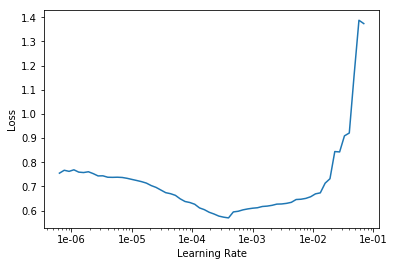

In [110]:
learner.lr_find()
learner.recorder.plot()

In [111]:
learner.fit_one_cycle(1, max_lr= 1e-04, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.362582,0.304076,0.874915,05:28


In [112]:
learner.fit_one_cycle(5, max_lr= 1e-04, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.245634,0.543296,0.843137,05:12
1,0.245596,0.276064,0.888438,05:18
2,0.193739,0.260084,0.910751,05:47
3,0.110787,0.262645,0.918864,06:01
4,0.066633,0.300045,0.913455,05:17


In [113]:
learner.freeze_to(-2)
learner.fit_one_cycle(5, max_lr= 1e-04, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [0]:
learner.export(file='chinese_hotel_reviews_classification.pkl')

In [114]:
learner.predict('臨時預定的房間,但房東都很快速且親切的回應!!房間的設備很不錯,乾淨又舒適｡附近居民相當熱心且熱情的與我們打招呼~ 只是可能因為位在一樓,早上隔音稍嫌不足~')

(Category pos, tensor(1), tensor([5.2032e-04, 9.9948e-01]))

In [115]:
learner.predict('超级推荐的民宿,特别法式的感觉｡')

(Category pos, tensor(1), tensor([5.7143e-04, 9.9943e-01]))

In [116]:
learner.predict('典型的国营酒店，管理层缺乏责任心，管理混乱。房间里的大灯镜灯台灯都是坏的，只有一盏床头灯可用')

(Category neg, tensor(0), tensor([0.9959, 0.0041]))

In [117]:
learner.predict('房间太旧了,价格上也不实惠,不过在信阳这样的城市估计也没有什么好酒店,也只能将就了!')

(Category neg, tensor(0), tensor([0.9960, 0.0040]))

In [118]:
learner.predict('除了位置有点难找确实是很棒的房子!')

(Category pos, tensor(1), tensor([5.7591e-04, 9.9942e-01]))